## Contest [Link](https://hack.univ.ai/)

In [1]:
import os

BASE_DIR = '/content/drive/MyDrive/Hackerearth/univ_ai'
os.chdir(BASE_DIR)

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Define Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchvision import transforms, utils

In [4]:
RANDOM_SEED = 22
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# dimention of each data point in input
n_feats = 11

class Classifier(nn.Module):
    def __init__(self, inp_dim=n_feats):
        super(Classifier, self).__init__()
        self.inp_dim = inp_dim
        self.l1 = nn.Linear(inp_dim, 10)
        self.bn1 = nn.BatchNorm1d(10)
        self.l2 = nn.Linear(10, 5)
        self.bn2 = nn.BatchNorm1d(5)
        self.l3 = nn.Linear(5, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.l1(x)))
        x = F.relu(self.bn2(self.l2(x)))
        x = self.l3(x)

        return x

In [70]:
model = Classifier().to(device)

optimizer = Adam(model.parameters())
criterian = nn.CrossEntropyLoss()

#### Create DataLoader and Dataset

In [12]:
class OurDataset(Dataset):
    def __init__(self, df):
        super(Dataset, self).__init__()
        self.df = df
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # return self.df.iloc[idx].to_list()
        feats = self.df[['income', 'age', 'experience', 'married', 'house_ownership',
                         'car_ownership', 'profession', 'city', 'state', 'current_job_years', 'current_house_years']].iloc[idx].to_list()
        label = -1 if 'risk_flag' not in self.df.columns else self.df[['risk_flag']].iloc[idx].item()
        return {'feats': torch.tensor(feats), 'label': label}

#### Load the data

In [7]:
import pandas as pd
import numpy as np

In [8]:
b_size = 486

In [63]:
train_df = pd.read_csv(BASE_DIR + '/processed_data/train.csv').head(7000) 

train_dataset = OurDataset(train_df)
train_dataloader = DataLoader(train_dataset, batch_size=b_size*10, shuffle=True)

In [21]:
for x in [train_dataset, train_dataloader]:
    y = next(iter(x))
    print(type(y['label']))

<class 'int'>
<class 'torch.Tensor'>


In [64]:
val_df = pd.read_csv(BASE_DIR + '/processed_data/val.csv').head(7000)

val_dataset = OurDataset(val_df)
val_dataloader = DataLoader(val_dataset, batch_size=b_size, shuffle=True)

In [54]:
len(train_dataloader.dataset), len(train_dataloader) * b_size, len(train_dataset)

(176400, 176418, 176400)

#### Training Loop

In [55]:
from tqdm.autonotebook import tqdm

def train(n_epoch, train_dataloader, val_dataloader, model, criterian, optimizer):
    _benchmark = [{
        'train': [], 'val': []
    }, {
        'train': [], 'val': []
    }]
    for epoch in range(n_epoch):
        print('='*20, f' [Epoch {epoch+1}] ', '='*20)
        for phase, loader in [('train', train_dataloader), ('val', val_dataloader)]:
            running_loss, running_acc = 0.0, 0.0
            if phase == 'train':
                model.train()
            else:
                model.eval()

            for batch in tqdm(loader, leave=False, position=0):
                optimizer.zero_grad()

                inputs, labels = batch['feats'], batch['label'].to(device)
                outs = model(inputs.to(device))
                loss = criterian(outs, labels.to(device))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item() * inputs.shape[0]
                running_acc += torch.sum(torch.argmax(outs, dim=1) == labels)

            running_loss /= len(loader.dataset)
            running_acc /= len(loader.dataset)
            _benchmark[0][phase].append(running_loss)
            _benchmark[1][phase].append(running_acc)

            print(f'{phase}: Loss {running_loss:.2f}, Acc: {running_acc:.2f}')

    return _benchmark


In [71]:
_losses, _accs = train(10, train_dataloader, val_dataloader, model, criterian, optimizer)
_benchmarks = [_losses, _accs]

====================  [Epoch 1]  ====================


train: Loss 0.79, Acc: 0.30


val: Loss 0.88, Acc: 0.12
====================  [Epoch 2]  ====================


train: Loss 0.78, Acc: 0.30


val: Loss 0.87, Acc: 0.12
====================  [Epoch 3]  ====================


train: Loss 0.78, Acc: 0.31


val: Loss 0.85, Acc: 0.12
====================  [Epoch 4]  ====================


train: Loss 0.77, Acc: 0.32


val: Loss 0.84, Acc: 0.12
====================  [Epoch 5]  ====================


train: Loss 0.76, Acc: 0.32


val: Loss 0.83, Acc: 0.12
====================  [Epoch 6]  ====================


train: Loss 0.75, Acc: 0.33


val: Loss 0.82, Acc: 0.12
====================  [Epoch 7]  ====================


train: Loss 0.75, Acc: 0.34


val: Loss 0.81, Acc: 0.12
====================  [Epoch 8]  ====================


train: Loss 0.74, Acc: 0.36


val: Loss 0.80, Acc: 0.13
====================  [Epoch 9]  ====================


train: Loss 0.73, Acc: 0.37


val: Loss 0.79, Acc: 0.14
====================  [Epoch 10]  ====================


train: Loss 0.73, Acc: 0.39


val: Loss 0.78, Acc: 0.15


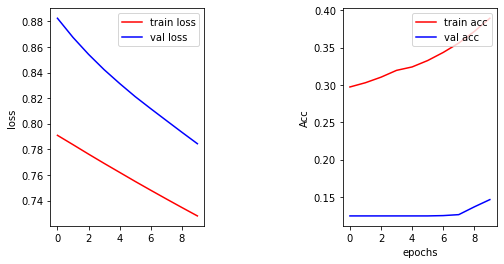

In [72]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4), gridspec_kw={'hspace': 0.2, 'wspace': 0.9})

axes[0].plot(_losses['train'], color='red', label='train loss')
axes[0].plot(_losses['val'], color='blue', label='val loss')
axes[0].legend(loc="upper right")
axes[0].set_ylabel('loss')
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

axes[1].plot(_accs['train'], color='red', label='train acc')
axes[1].plot(_accs['val'], color='blue', label='val acc')
axes[1].legend(loc="upper right")
axes[1].set_ylabel('Acc')
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xlabel('epochs')
plt.show()

saving and loading models [1](https://pytorch.org/tutorials/beginner/saving_loading_models.html#id1)

In [84]:
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'benchmarks': _benchmarks,
#     'n_epochs': 3,
#     'details': 'Trained on full dataset.'
# }, BASE_DIR + '/checkpoints/Apr4.h5')

In [77]:
! ls checkpoints

Apr2.h5  Apr3.h5


Loading checkpoints

In [81]:
checkpoint = torch.load(BASE_DIR + '/checkpoints/Apr3.h5')

In [82]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

#### Evaluate on test split

In [75]:
test_df = pd.read_csv(BASE_DIR + '/processed_data/val.csv')

test_dataset = OurDataset(test_df)
test_dataloader = DataLoader(test_dataset, b_size * 3, shuffle=True)

In [83]:
running_loss, running_acc = 0.0, 0.0
model.eval()

for batch in tqdm(test_dataloader, leave=False, position=0):
    inputs, labels = batch['feats'], batch['label'].to(device)

    outs = model(inputs.to(device))
    loss = criterian(outs, labels.to(device))

    running_loss += loss.item() * inputs.shape[0]
    running_acc += torch.sum(torch.argmax(outs, dim=1) == labels)

running_loss /= len(test_dataloader.dataset)
running_acc /= len(test_dataloader.dataset)

print(f'Acc: {running_acc:.2f}, Loss: {running_loss:.2f}')

Acc: 0.88, Loss: 0.37
